In [1]:
#@title Download L5 Sample Dataset and install L5Kit
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !wget https://raw.githubusercontent.com/lyft/l5kit/master/examples/setup_notebook_colab.sh -q
    !sh ./setup_notebook_colab.sh
    os.environ["L5KIT_DATA_FOLDER"] = open("./dataset_dir.txt", "r").read().strip()
else:
    os.environ["L5KIT_DATA_FOLDER"] = "/mnt/scratch/v_liuhaolan/l5kit_data"
    print("Not running in Google Colab.")

Not running in Google Colab.


In [2]:
import matplotlib.pyplot as plt

import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

import os

from l5kit.visualization.visualizer.zarr_utils import zarr_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

In [3]:
# Dataset is assumed to be on the folder specified
# in the L5KIT_DATA_FOLDER environment variable

# get config
cfg = load_config_data("./visualization_config.yaml")
print(cfg)

{'format_version': 4, 'debug': True, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 4, 'future_num_frames': 12, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [112, 112], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train_full.zarr', 'batch_size': 64, 'shuffle': True, 'num_workers': 16}}


In [4]:
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   134622   |  33437057  | 2655096629 |   314473872   |      928.68     |        248.38        |        79.41         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [5]:
rast = build_rasterizer(cfg, dm)
#dataset = EgoDataset(cfg, zarr_dataset, rast)

#preprocessed_dir = "/mnt/scratch/v_liuhaolan/preprocessed_goal"
preprocessed_dir = "/mnt/scratch/v_liuhaolan/preprocessed_goal"


from l5kit.dataset import CachedEgoDataset

train_zarr = ChunkedDataset(dm.require(cfg["val_data_loader"]["key"])).open()
train_dataset = CachedEgoDataset(cfg, train_zarr, rast, preprocessed_path=preprocessed_dir)



Debug: Read preprocessed dataset into memory...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 2716.97it/s]


0.040821075439453125


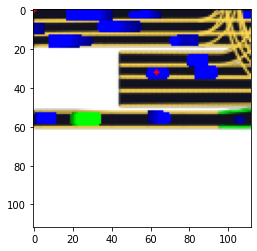

dict_keys(['frame_index', 'image', 'target_positions', 'target_yaws', 'target_velocities', 'target_availabilities', 'history_positions', 'history_yaws', 'history_velocities', 'history_availabilities', 'world_to_image', 'raster_from_agent', 'raster_from_world', 'agent_from_world', 'world_from_agent', 'centroid', 'yaw', 'extent', 'history_extents', 'future_extents', 'curr_speed', 'scene_index', 'host_id', 'timestamp', 'track_id', 'goal_list', 'goal_num', 'goal_gt', 'gt_heatmap', 'goal_pixel', 'road_mask', 'ocg', 'obj_num'])


In [11]:
#data = train_dataset[65]

#data = train_dataset[12]

# 65 is with perturb!

#data = train_dataset[703]
from time import time
start = time()
data = train_dataset[603]
print(time()-start)

#im = data["image"].transpose(1, 2, 0)
im = data["image"].transpose(1,2,0)
im = train_dataset.rasterizer.to_rgb(im)

im= np.ascontiguousarray(im, dtype=np.uint8)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
#draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

import cv2
ocg = data["ocg"]
for i in ocg:
#    print(i)
    cv2.circle(im, (int(i[0]), int(i[1])), radius=1, color=(255, 0, 0), thickness=-1)


plt.imshow(im)
plt.show()

print(data.keys())


In [ ]:
mask = data["road_mask"]

plt.imshow(mask, cmap=plt.get_cmap('gray'))


In [ ]:
data["obj_num"]

In [ ]:
data = train_dataset[377]
# 65 is with perturb!


#im = data["image"].transpose(1, 2, 0)
im = data["image"].transpose(1,2,0)
im = train_dataset.rasterizer.to_rgb(im)

#target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
#draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
im= np.ascontiguousarray(im, dtype=np.uint8)
import cv2
ocg = data["ocg"]
for i in ocg:
#    print(i)
    cv2.circle(im, (int(i[0]), int(i[1])), radius=1, color=(255, 0, 0), thickness=-1)


plt.imshow(im)
plt.show()

In [ ]:
print(len(ocg))

In [ ]:

idx = 17895
data = dataset[idx]



#im = data["image"].transpose(1, 2, 0)
im = data["image"].transpose(1,2,0)
im = dataset.rasterizer.to_rgb(im)

target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])


plt.imshow(im)
plt.show()

mask = dataset.get_mask(idx)


ocg, agent_aux = mask["ocg"]
import cv2
for i in ocg:
    print(i)
    cv2.circle(im, (int(i[0]), int(i[1])), radius=1, color=(255, 0, 0), thickness=-1)

plt.imshow(im)
plt.show()


In [ ]:
idx = 17907
data = dataset[idx]



#im = data["image"].transpose(1, 2, 0)
im = data["image"].transpose(1,2,0)
im = dataset.rasterizer.to_rgb(im)

target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
plt.imshow(im)
plt.show()

In [ ]:
print((agent_aux["track_id"]))